In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
df = pd.read_pickle('data/train_set.pkl')
df.head()

,prices,compound,neg,neu,pos
2007-01-01,12469,-0.9851,0.160,0.738,0.102
2007-01-02,12472,0.4395,0.117,0.775,0.109
2007-01-03,12474,-0.9995,0.192,0.748,0.060
2007-01-04,12480,-0.9973,0.113,0.827,0.060
2007-01-05,12398,0.9726,0.082,0.829,0.089


In [3]:
train_end = '2014-12-31'
test_start = '2015-01-01'
train_x = df.loc[:train_end]
test_x = df.loc[test_start:]
train_y = train_x.prices
test_y = test_x.prices
train_x = train_x.drop('prices', axis='columns')
test_x = test_x.drop('prices', axis='columns')

In [4]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(train_x, train_y)

C:\Users\kduar_000\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [5]:
pred = rf.predict(test_x)
pred_df = pd.DataFrame(data=pred, index=test_x.index, columns=['pred_prices'])
pred_df.head()

,pred_prices
2015-01-01,12703.5
2015-01-02,13541.3
2015-01-03,11498.0
2015-01-04,13601.4
2015-01-05,12223.4


In [6]:
r2_score(test_y, pred_df)

-39.70738951298598

### GradientBoostingRegressor 적용

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(train_x, train_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [30]:
pred_model = model.predict(test_x)
pred_dfM = pd.DataFrame(data=pred_model, index=test_x.index, columns=['pred_prices'])

In [31]:
r2_score(test_y, pred_dfM)

-39.00483913208285

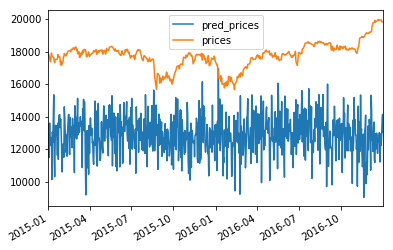

In [10]:
ax = pred_df.plot()
fig = pd.DataFrame(test_y).plot(ax=ax)

In [11]:
train_pred = rf.predict(train_x)
train_pred = pd.Series(train_pred, index=train_x.index)

In [12]:
len(train_x)

2921

In [13]:
days = 5
day_int = np.arange(days, len(train_x)-days, days)
day_int

array([   5,   10,   15,   20,   25,   30,   35,   40,   45,   50,   55,
         60,   65,   70,   75,   80,   85,   90,   95,  100,  105,  110,
        115,  120,  125,  130,  135,  140,  145,  150,  155,  160,  165,
        170,  175,  180,  185,  190,  195,  200,  205,  210,  215,  220,
        225,  230,  235,  240,  245,  250,  255,  260,  265,  270,  275,
        280,  285,  290,  295,  300,  305,  310,  315,  320,  325,  330,
        335,  340,  345,  350,  355,  360,  365,  370,  375,  380,  385,
        390,  395,  400,  405,  410,  415,  420,  425,  430,  435,  440,
        445,  450,  455,  460,  465,  470,  475,  480,  485,  490,  495,
        500,  505,  510,  515,  520,  525,  530,  535,  540,  545,  550,
        555,  560,  565,  570,  575,  580,  585,  590,  595,  600,  605,
        610,  615,  620,  625,  630,  635,  640,  645,  650,  655,  660,
        665,  670,  675,  680,  685,  690,  695,  700,  705,  710,  715,
        720,  725,  730,  735,  740,  745,  750,  7

In [14]:
days = 5
day_int = np.arange(days, len(train_x)-days, days)
total_days=0
mean_diff = 0
for day in day_int:
    act_mean = train_y[(day-days):day].mean()
    pred_mean = train_pred[day:(day+days)].mean()
    mean_diff += (pred_mean-act_mean)
    total_days += 1
mean_diff = mean_diff / total_days
mean_diff

13.709342481418153

In [15]:
pred_df['ewm_prices'] = pred_df.ewm(span=60).mean() + mean_diff
pred_df.head()

,pred_prices,ewm_prices
2015-01-01,12703.5,12717.209342
2015-01-02,13541.3,13143.091009
2015-01-03,11498.0,12581.071642
2015-01-04,13601.4,12852.647722
2015-01-05,12223.4,12721.198428


In [16]:
r2_score(test_y, pred_df.ewm_prices)

-37.25823431091108

### 60일에서 5일로 구간을 줄였더니 더 좋아졌다

In [18]:
# 지수 이동평균 구하기
#pred_df['ewm_prices'] = pred_df.ewm(span=60).mean() + mean_diff
pred_df['ewm_prices'] = pred_df.ewm(span=5).mean() + mean_diff

In [19]:
r2_score(test_y, pred_df.ewm_prices)

-37.7206443736274

In [24]:
pred_df.head()

,pred_prices,ewm_prices
2015-01-01,12703.5,12717.209342
2015-01-02,13541.3,13219.889342
2015-01-03,11498.0,12410.751448
2015-01-04,13601.4,12911.023189
2015-01-05,12223.4,12652.316925


GradientBoostingRegressor 에 지수 이동평균을 적용했더니 성능이 좀 더 좋아졌다.

In [28]:
pred_dfM['ewm_prices'] = pred_dfM.ewm(span=5).mean() + mean_diff
r2_score(test_y, pred_dfM.ewm_prices)

-38.477178472959096

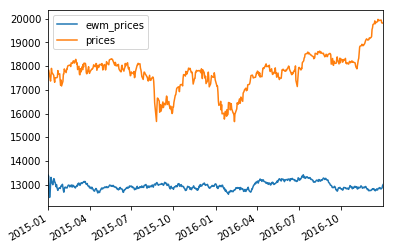

In [16]:
ax = pred_df[['ewm_prices']].plot()
fig = pd.DataFrame(test_y).plot(ax=ax)